# GradCAM Visualization Demo with ResNet101


In [1]:
# Replace vanila relu to guided relu to get guided backpropagation.
import tensorflow as tf

from tensorflow.python.framework import ops
from tensorflow.python.ops import gen_nn_ops

@ops.RegisterGradient("GuidedRelu")
def _GuidedReluGrad(op, grad):
    return tf.where(0. < grad, gen_nn_ops._relu_grad(grad, op.outputs[0]), tf.zeros(grad.get_shape()))

/home/naver/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
See visualization of below category
Top1:  n02108551 Tibetan mastiff 1
Top5:  [('n02108551 Tibetan mastiff', 1), ('n15075141 toilet tissue, toilet paper, bathroom tissue', 0), ('n02319095 sea urchin', 0), ('n02395406 hog, pig, grunter, squealer, Sus scrofa', 0), ('n02391049 zebra', 0)]
Top1:  n02033041 dowitcher 1.0
Top5:  [('n02033041 dowitcher', 1.0), ('n15075141 toilet tissue, toilet paper, bathroom tissue', 0.0), ('n02321529 sea cucumber, holothurian', 0.0), ('n02395406 hog, pig, grunter, squealer, Sus scrofa', 0.0), ('n02391049 zebra', 0.0)]


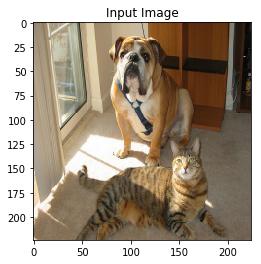

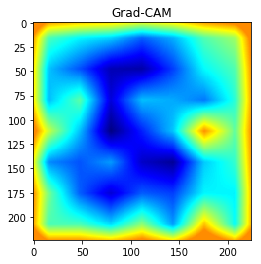

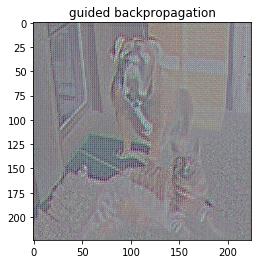

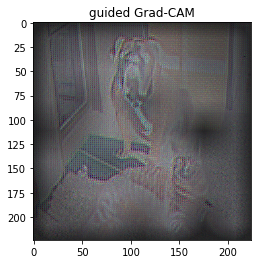

See visualization of below category
Top1:  n02086910 papillon 1
Top5:  [('n02086910 papillon', 1), ('n15075141 toilet tissue, toilet paper, bathroom tissue', 0), ('n02321529 sea cucumber, holothurian', 0), ('n02395406 hog, pig, grunter, squealer, Sus scrofa', 0), ('n02391049 zebra', 0)]
Top1:  n02033041 dowitcher 1.0
Top5:  [('n02033041 dowitcher', 1.0), ('n15075141 toilet tissue, toilet paper, bathroom tissue', 0.0), ('n02321529 sea cucumber, holothurian', 0.0), ('n02395406 hog, pig, grunter, squealer, Sus scrofa', 0.0), ('n02391049 zebra', 0.0)]


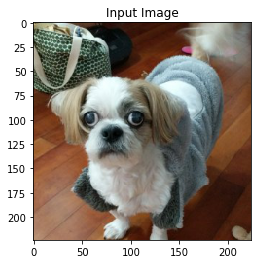

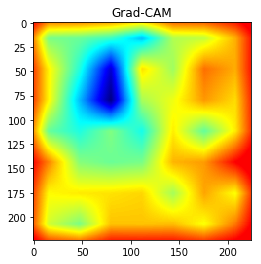

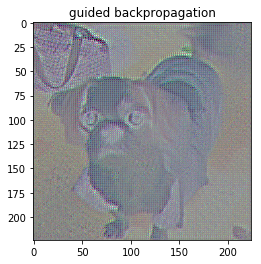

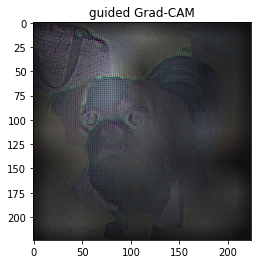

See visualization of below category
Top1:  n02129604 tiger, Panthera tigris 1
Top5:  [('n02129604 tiger, Panthera tigris', 1), ('n15075141 toilet tissue, toilet paper, bathroom tissue', 0), ('n02319095 sea urchin', 0), ('n02391049 zebra', 0), ('n02389026 sorrel', 0)]
Top1:  n02033041 dowitcher 1.0
Top5:  [('n02033041 dowitcher', 1.0), ('n15075141 toilet tissue, toilet paper, bathroom tissue', 0.0), ('n02321529 sea cucumber, holothurian', 0.0), ('n02395406 hog, pig, grunter, squealer, Sus scrofa', 0.0), ('n02391049 zebra', 0.0)]


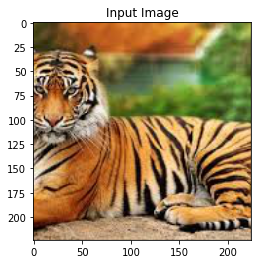

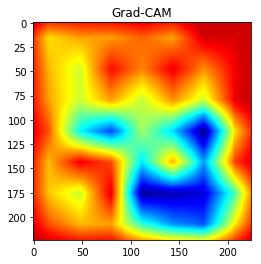

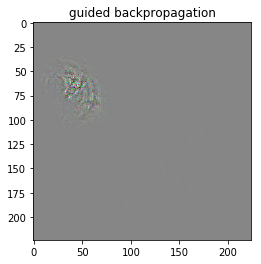

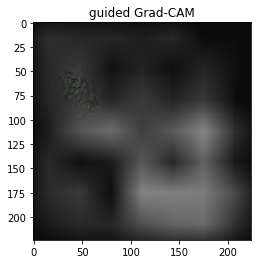

In [7]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np

from nets import resnet_v1
slim = tf.contrib.slim


import utils


def preprocess(resized_inputs):
    """Faster R-CNN Resnet V1 preprocessing.

    VGG style channel mean subtraction as described here:
    https://gist.github.com/ksimonyan/211839e770f7b538e2d8#file-readme-md

    Args:
      resized_inputs: A [batch, height_in, width_in, channels] float32 tensor
        representing a batch of images with values between 0 and 255.0.

    Returns:
      preprocessed_inputs: A [batch, height_out, width_out, channels] float32
        tensor representing a batch of images.

    """
    channel_means = [123.68, 116.779, 103.939]
    return resized_inputs * 255 - [[channel_means]]


# Create mini-batch for demo

img1 = utils.load_image("./demo.png")
img2 = utils.load_image("./shihtzu_mypuppy.jpg")
img3 = utils.load_image("./tiger.jpg")

batch1_img = img1.reshape((1, 224, 224, 3))
batch1_label = np.array([1 if i == 244 else 0 for i in range(1000)])  # 1-hot result for Boxer
batch1_label = batch1_label.reshape(1, -1)

batch2_img = img2.reshape((1, 224, 224, 3))
batch2_label = np.array([1 if i == 157 else 0 for i in range(1000)])  # 1-hot result for Shih-Tzu
batch2_label = batch2_label.reshape(1, -1)

batch3_img = img3.reshape((1, 224, 224, 3))
batch3_label = np.array([1 if i == 292 else 0 for i in range(1000)])  # 1-hot result for tiger
batch3_label = batch3_label.reshape(1, -1)

batch_img = np.concatenate((batch1_img, batch2_img, batch3_img), 0)
batch_label = np.concatenate((batch1_label, batch2_label, batch3_label), 0)

batch_size = 3


# Create tensorflow graph for evaluation
eval_graph = tf.Graph()
with eval_graph.as_default():
    with eval_graph.gradient_override_map({'Relu': 'GuidedRelu'}):
        images = tf.placeholder("float", [batch_size, 224, 224, 3])
        labels = tf.placeholder(tf.float32, [batch_size, 1000])
        train_mode = tf.placeholder(tf.bool)
        
        # preprocessed_images = images
        preprocessed_images = preprocess(images)
        
        with slim.arg_scope(resnet_v1.resnet_arg_scope()):
            net, end_points = resnet_v1.resnet_v1_101(preprocessed_images, 1000, is_training=train_mode)
        prob = end_points['predictions'] # after softmax
        
        # sess_config.graph_options.optimizer_options.global_jit_level = tf.OptimizerOptions.OFF
        cost = tf.reduce_sum((prob - labels) ** 2)
        train = tf.train.GradientDescentOptimizer(0.0001).minimize(cost)

        # Get last convolutional layer gradient for generating gradCAM visualization
        # print('endpoints:', end_points.keys())
        target_conv_layer = end_points['resnet_v1_101/block4']
        target_conv_layer_grad = tf.gradients(cost, target_conv_layer)[0]

        # Guided backpropagtion back to input layer
        gb_grad = tf.gradients(cost, images)[0]

        # Normalizing the gradients    
        target_conv_layer_grad_norm = tf.div(target_conv_layer_grad, tf.sqrt(tf.reduce_mean(tf.square(target_conv_layer_grad))) + tf.constant(1e-5))


        init = tf.global_variables_initializer()

        
# Run tensorflow 

with tf.Session(graph=eval_graph) as sess:    
    sess.run(init)
    
    prob = sess.run(prob, feed_dict={images: batch_img, train_mode: False})
    print(prob)
    
    gb_grad_value, target_conv_layer_value, target_conv_layer_grad_value = sess.run([gb_grad, target_conv_layer, target_conv_layer_grad_norm], feed_dict={images: batch_img, labels: batch_label, train_mode: True})
    
    for i in range(batch_size):
        print('See visualization of below category')
        utils.print_prob(batch_label[i], './synset.txt')
        utils.print_prob(prob[i], './synset.txt')
        utils.visualize(batch_img[i], target_conv_layer_value[i], target_conv_layer_grad_value[i], gb_grad_value[i])
    